In [154]:
#         Prerequisite

from sqlalchemy import create_engine
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt     
get_ipython().magic('matplotlib inline')
import seaborn as sns               
from IPython.display import display
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, train_test_split
from collections import defaultdict
from scipy.stats import hmean
from scipy.spatial.distance import cdist
from scipy import stats
import numbers
import sqlite3



def weighted_hamming(data):
    
    categories_dist = []
    
    for category in data:
        X = pd.get_dummies(data[category])
        X_mean = X * X.mean()
        X_dot = X_mean.dot(X.transpose())
        X_np = np.asarray(X_dot.replace(0,1,inplace=False))
        categories_dist.append(X_np)
    categories_dist = np.array(categories_dist)
    distances = hmean(categories_dist, axis=0)
    return distances


def distance_matrix(data, numeric_distance = "euclidean", categorical_distance = "jaccard"):
    
    possible_continuous_distances = ["euclidean", "cityblock"]
    possible_binary_distances = ["euclidean", "jaccard", "hamming", "weighted-hamming"]
    number_of_variables = data.shape[1]
    number_of_observations = data.shape[0]

    is_numeric = [all(isinstance(n, numbers.Number) for n in data.iloc[:, i]) for i, x in enumerate(data)]
    is_all_numeric = sum(is_numeric) == len(is_numeric)
    is_all_categorical = sum(is_numeric) == 0
    is_mixed_type = not is_all_categorical and not is_all_numeric

    if numeric_distance not in possible_continuous_distances:
        print ("The continuous distance " + numeric_distance + " is not supported.")
        return None
    elif categorical_distance not in possible_binary_distances:
        print ("The binary distance " + categorical_distance + " is not supported.")
        return None

    if is_mixed_type:
        number_of_numeric_var = sum(is_numeric)
        number_of_categorical_var = number_of_variables - number_of_numeric_var
        data_numeric = data.iloc[:, is_numeric]
        data_numeric = (data_numeric - data_numeric.mean()) / (data_numeric.max() - data_numeric.min())
        data_categorical = data.iloc[:, [not x for x in is_numeric]]

    
    if is_mixed_type:
        data_numeric.fillna(data_numeric.mean(), inplace=True)
        for x in data_categorical:
            data_categorical[x].fillna(data_categorical[x].mode()[0], inplace=True)
    elif is_all_numeric:
        data.fillna(data.mean(), inplace=True)
    else:
        for x in data:
            data[x].fillna(data[x].mode()[0], inplace=True)

    if not is_all_numeric and not (categorical_distance == 'hamming' or categorical_distance == 'weighted-hamming'):
        if is_mixed_type:
            data_categorical = pd.get_dummies(data_categorical)
        else:
            data = pd.get_dummies(data)
    elif not is_all_numeric and categorical_distance == 'hamming':
        if is_mixed_type:
            data_categorical = pd.DataFrame([pd.factorize(data_categorical[x])[0] for x in data_categorical]).transpose()
        else:
            data = pd.DataFrame([pd.factorize(data[x])[0] for x in data]).transpose()

    if is_all_numeric:
        result_matrix = cdist(data, data, metric=numeric_distance)
    elif is_all_categorical:
        if categorical_distance == "weighted-hamming":
            result_matrix = weighted_hamming(data)
        else:
            result_matrix = cdist(data, data, metric=categorical_distance)
    else:
        result_numeric = cdist(data_numeric, data_numeric, metric=numeric_distance)
        if categorical_distance == "weighted-hamming":
            result_categorical = weighted_hamming(data_categorical)
        else:
            result_categorical = cdist(data_categorical, data_categorical, metric=categorical_distance)
        result_matrix = np.array([[1.0*(result_numeric[i, j] * number_of_numeric_var + result_categorical[i, j] *
                               number_of_categorical_var) / number_of_variables for j in range(number_of_observations)] for i in range(number_of_observations)])

    np.fill_diagonal(result_matrix, np.nan)

    return pd.DataFrame(result_matrix)


def knn_impute(target, attributes, k_neighbors, aggregation_method="mean", numeric_distance="euclidean",
               categorical_distance="jaccard", missing_neighbors_threshold = 0.5):
   

    possible_aggregation_method = ["mean", "median", "mode"]
    number_observations = len(target)
    is_target_numeric = all(isinstance(n, numbers.Number) for n in target)

    if number_observations < 3:
        print ("Not enough observations.")
        return None
    if attributes.shape[0] != number_observations:
        print("The number of observations in the attributes variable is not matching the target variable length.")
        return None
    if k_neighbors > number_observations or k_neighbors < 1:
        print ("The range of the number of neighbors is incorrect.")
        return None
    if aggregation_method not in possible_aggregation_method:
        print ("The aggregation method is incorrect.")
        return None
    if not is_target_numeric and aggregation_method != "mode":
        print ("The only method allowed for categorical target variable is the mode.")
        return None

    target = pd.DataFrame(target)
    attributes = pd.DataFrame(attributes)

    distances = distance_matrix(attributes, numeric_distance, categorical_distance)
    if distances is None:
        return None

    for i, value in enumerate(target.iloc[:, 0]):
        if pd.isnull(value):
            order = distances.iloc[i,:].values.argsort()[:k_neighbors]
            closest_to_target = target.iloc[order, :]
            missing_neighbors = [x for x  in closest_to_target.isnull().iloc[:, 0]]
            if sum(missing_neighbors) >= missing_neighbors_threshold * k_neighbors:
                continue
            elif aggregation_method == "mean":
                target.iloc[i] = np.ma.mean(np.ma.masked_array(closest_to_target,np.isnan(closest_to_target)))
            elif aggregation_method == "median":
                target.iloc[i] = np.ma.median(np.ma.masked_array(closest_to_target,np.isnan(closest_to_target)))
            else:
                target.iloc[i] = stats.mode(closest_to_target, nan_policy='omit')[0][0]

    return target

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)


--------------The Accuracy of the model----------------------------
The accuracy of the Random Forest Classifier is 70.1
The cross validated score for Random Forest Classifier is: 67.75


,index,p1,p2,p4,p5,p6,p7,p8,p10,p11,p12,p13,0,target
0,0,2358.0,343.0,162.0,49.0,1332.0,202.0,227.0,350.0,0.0,0.0,0.0,6.0,3.0
1,1,2365.0,267.0,42.0,6.0,1355.0,155.0,242.0,365.0,0.0,0.0,0.0,6.0,6.0
2,2,2791.0,57.0,0.0,0.0,1595.0,227.0,219.0,1724.0,0.0,0.0,1.0,5.0,5.0
3,3,2376.0,313.0,85.0,32.0,361.0,154.0,217.0,807.0,0.0,0.0,0.0,6.0,3.0
4,4,2298.0,126.0,395.0,4.0,1103.0,253.0,206.0,612.0,0.0,0.0,0.0,4.0,4.0
5,5,2821.0,55.0,268.0,166.0,283.0,226.0,180.0,1448.0,1.0,0.0,0.0,5.0,5.0
6,6,3108.0,48.0,30.0,10.0,3868.0,219.0,175.0,934.0,1.0,0.0,0.0,1.0,1.0
7,7,2795.0,18.0,658.0,61.0,330.0,212.0,218.0,994.0,0.0,0.0,1.0,5.0,5.0
8,8,2330.0,76.0,0.0,0.0,402.0,222.0,235.0,1356.0,0.0,0.0,0.0,4.0,4.0
9,9,2290.0,250.0,228.0,57.0,1650.0,183.0,250.0,824.0,0.0,0.0,0.0,4.0,6.0


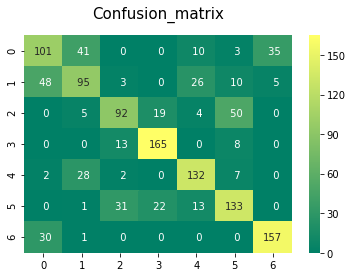

In [163]:
#         Read Dataframe From Database  (Dataset)


engine = create_engine('sqlite:///MyDB.db', echo=False)
mytest_median=pd.read_sql_query("select * from Dataset;", engine)
mytest_median = mytest_median.drop('index',axis=1)
mytest_median = mytest_median.drop('p9',axis=1)
mytest_median = mytest_median.drop('p3',axis=1)


#         Deal Miss Values


for col in cols:
    knn_impute(target=mytest_median[col], attributes=mytest_median.drop([col, 'Id'], 1),
               aggregation_method="median", k_neighbors=10, numeric_distance='euclidean',
               categorical_distance='hamming', missing_neighbors_threshold=0.8)
mytest_median=clean_dataset(mytest_median)    
    
    
#         Split Dataset Into Test and Train


all_features = mytest_median.drop(["Id","target"],axis=1)
Targeted_feature = mytest_median["target"]
X_train,X_test,y_train,y_test = train_test_split(all_features,Targeted_feature,test_size=0.3,random_state=42)


#         Model


from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(criterion='gini', n_estimators=700,
                             min_samples_split=10,min_samples_leaf=1,
                             max_features='auto',oob_score=True,
                             random_state=1,n_jobs=-1)
model.fit(X_train,y_train)
prediction_rm=model.predict(X_test)
print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the Random Forest Classifier is',round(accuracy_score(prediction_rm,y_test)*100,2))
kfold = KFold(n_splits=10, random_state=22) # k=10, split the data into 10 equal parts
result_rm=cross_val_score(model,all_features,Targeted_feature,cv=10,scoring='accuracy')
print('The cross validated score for Random Forest Classifier is:',round(result_rm.mean()*100,2))
y_pred = cross_val_predict(model,all_features,Targeted_feature,cv=10)
sns.heatmap(confusion_matrix(Targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)


#         Write Predict Values Into Database (PredictTable)


X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
result = pd.concat([X_test, pd.DataFrame(prediction_rm), y_test], axis=1, join='inner')
result.to_sql("PredictTable", engine, if_exists="replace")


#         Read Predicted Results


pd.read_sql_query("select * from PredictTable;", engine)


